# Mixture Models

One common objective is to find similarities in data and cluster it. There are several heuristic methods to cluster them. We are going to focus on a few strongly theoretically motivated methods. Other methods use heuristics to identify similarities in data and are mentioned in the end.

For the purposes of this example, we will generate a fake dataset.

We start by loading the necessary Python modules.

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans

Let's generate the fake data now to have something to cluster.

In [2]:
def generate_clusters(mu: np.ndarray, sigma: np.ndarray, N: int) ->np.ndarray:
    assert len(mu) == len(sigma)
    assert N > 1
    D = len(mu[0].shape)
    data = np.concatenate([np.random.default_rng().multivariate_normal(mean=mu_k, cov=sigma_k, size=N)
                           for mu_k, sigma_k in zip(mu, sigma)], axis=0)
    source = np.concatenate([k*np.ones([N, 1]) for k in range(len(mu))], axis=0)
    return np.concatenate([data, source], axis=1)


In [6]:
data = generate_clusters(mu=[np.array([5.0, -2.0]),
                             np.array([1.0, 5.0]),
                             np.array([-5.0, -1.0])],
                         sigma=[np.array([[0.4, 0.2],
                                          [0.2, 0.4]]),
                                np.array([[1.0, 0.5],
                                          [0.5, 1.0]]),
                                np.array([[2.0, 0.0],
                                          [0.0, 5.0]])],
                         N=1000)
data = pd.DataFrame(data, columns=["x", "y", "source"])

Let's print out the dataset read first.

In [7]:
data

,x,y,source
0,4.960065,-2.902600,0.0
1,6.231718,-1.404399,0.0
2,3.985313,-2.833486,0.0
3,5.314968,-1.930364,0.0
4,5.652647,-1.523516,0.0
...,...,...,...
2995,-6.289552,-1.923758,2.0
2996,-7.690072,1.032256,2.0
2997,-2.930869,-0.503878,2.0
2998,-3.721900,3.096010,2.0


We can plot this fairly easily using Matplotlib.

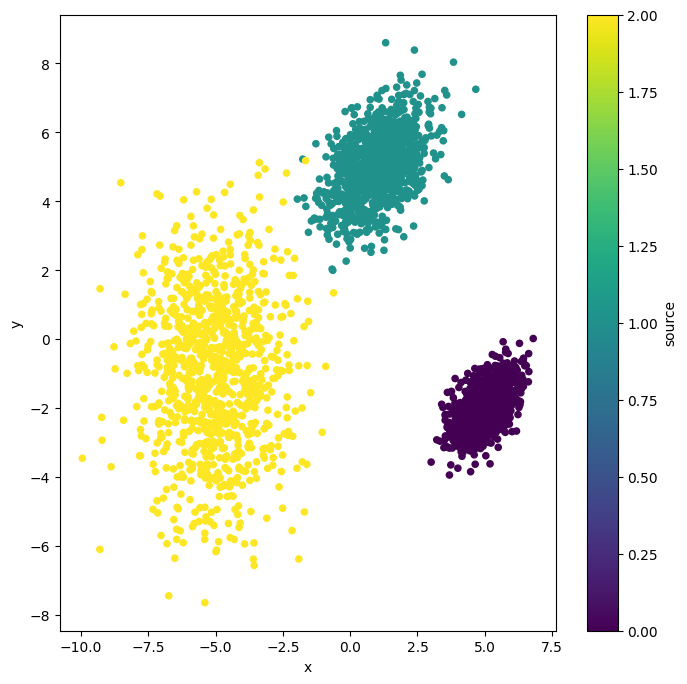

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
data.plot.scatter(x="x", y="y", c="source", colormap='viridis', ax=ax)
ax.set(xlabel="x", ylabel=r"y", title="")
plt.show()

There are several ways of finding similarities in the data. The Gaussian Mixture Model assumes that the data has been produced exactly as in this example. For each sample, the procedure assumed to be used for the generation of each sample is the following:
  * a random integer is chosen according to a discrete probability distribution, which identifies to which cluster the sample belongs to (this is the `source` variable in the generation procedure above);
  * that random integer is assumed to be used to choose the mean and covariance matrix for a Gaussian random variable, which is then used to produce the observed sample.
 
Our objective here is then to find out the probability of producing a sample for each cluster (the probabilities with which a sample belongs to one cluster instead of the others), the means and covariance matrices for the model. Using Bayes' theorem, one may write down the posterior probability for the true means, covariances and cluster probabilities ($\theta$) given the data ($x$), but it is very hard to calculate the parameters from it. Let us call the cluster that a specific sample belongs to, $z$.

The true posterior would look like this:

$p(\theta|x) = \frac{p(x|\theta) p(\theta)}{p(x)}$

We assume $p(\theta)$ is constant for all $\theta$ and we know $p(x)$ is independent of $\theta$ (because it is just the probability we obtained the existing data). We also know that $p(x|\theta) = \sum_z p(x,z|\theta)$, since summing over all $z$, we obtain a total probability 1 of getting any $z$.

$p(\theta|x) \propto \sum_z p(x,z|\theta) = \sum_z p(x|\theta,z) p(z|\theta)$

Where we have expanded it on $z$ using $p(a,b) = p(a|b)p(b)$.

Now if we want to find the most probable $\theta$ from this posterior (the "maximum a posteriori", or "MAP"), we just need to maximize the right-hand side of the last equation. This is very hard to do, but we can use the Expectation-Maximization (EM) algorithm, on which we iteratively improve our probability estimates. This method works as follows.

First we define the log-likelihood $LL(\theta|z) = \log L(\theta|z) = \log p(x|\theta,z) = \sum_{k=\text{sample}} \log p(x_k|\theta,z_k)$. Since we are assuming that the probability for each data sample $x_k$ is a Gaussian distribution, each of the terms in the sum is a Gaussian probability, so if we know $\theta$ and $z_k$, this full sum can be calculated. The issue is that we do not know $z_k$ (that is the whole point!).

We start by assuming $\theta=\theta_0$ for some random initial value of the parameters. The EM method iterates on two steps:

  1. Calculate the *average* value of $LL(\theta|z)$ over $z$ assuming the current $\theta_i$ to calculate $p(z|\theta)$, that is: $Q(\theta) = \sum_z LL(\theta|z) p(z|\theta_i)$. This means we calculate the weighted sum of the log-likelihood a point belongs to each Gaussian, weighted by the probability that that Gaussian was the reason that sample was generated. This avoids needing to know the correct $z_k$, since we just sum over all possibilities. The weights of this weighted sum are simply one of the parameters $\theta$, namely, the cluster probabilities.
  
  2. Find the $\theta$ which maximizes $Q(\theta)$ and use this as the next $\theta_{i+1}$.

These two steps are iterated to improve the $\theta$ for several iterations. It can be shown that an improvement on $Q$ following this procedure leads to a new $\theta$ that improves the posterior probability $p(\theta|x)$ above (see https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm#Proof_of_correctness ).

We will not write all of this from scratch. Instead, we use the `GaussianMixture` function in `scikit-learn`, which has this ready for us. It is nevertheless important to understand the assumptions made here: the underlying samples are assumed to come from a discrete combination of Gaussians. Other mixture models are possible using other underlying distributions, but note that this method will not work if the samples do not follow this generative pattern.

In [9]:
gmm = GaussianMixture(n_components=3, covariance_type="full", max_iter=20)

In [10]:
gmm.fit(data.loc[:, ["x", "y"]])

GaussianMixture(max_iter=20, n_components=3)

Now that we have model fit, we can even check the fit parameters $\theta$, which include the means, the covariance matrices and the probabilities given to each Gaussian in the mixture:

In [11]:
gmm.means_

array([[ 0.99087075,  5.04466165],
       [-5.06356078, -0.94701357],
       [ 4.97867027, -1.98953164]])

In [12]:
gmm.covariances_

array([[[ 9.80327267e-01,  4.34733962e-01],
        [ 4.34733962e-01,  9.46532120e-01]],

       [[ 1.94905096e+00, -1.15878394e-03],
        [-1.15878394e-03,  4.73462596e+00]],

       [[ 3.86398255e-01,  1.99692091e-01],
        [ 1.99692091e-01,  3.77042067e-01]]])

In [13]:
gmm.weights_

array([0.33400535, 0.33266132, 0.33333333])

We can predict to which cluster each sample belongs now by selecting the cluster for each sample that maximizes the probability $p(z|\theta,x)$, now that we know $\theta$.

In [14]:
guess = gmm.predict(data.loc[:, ["x", "y"]])

Let's plot it!

In [15]:
data.loc[:, "guess"] = guess

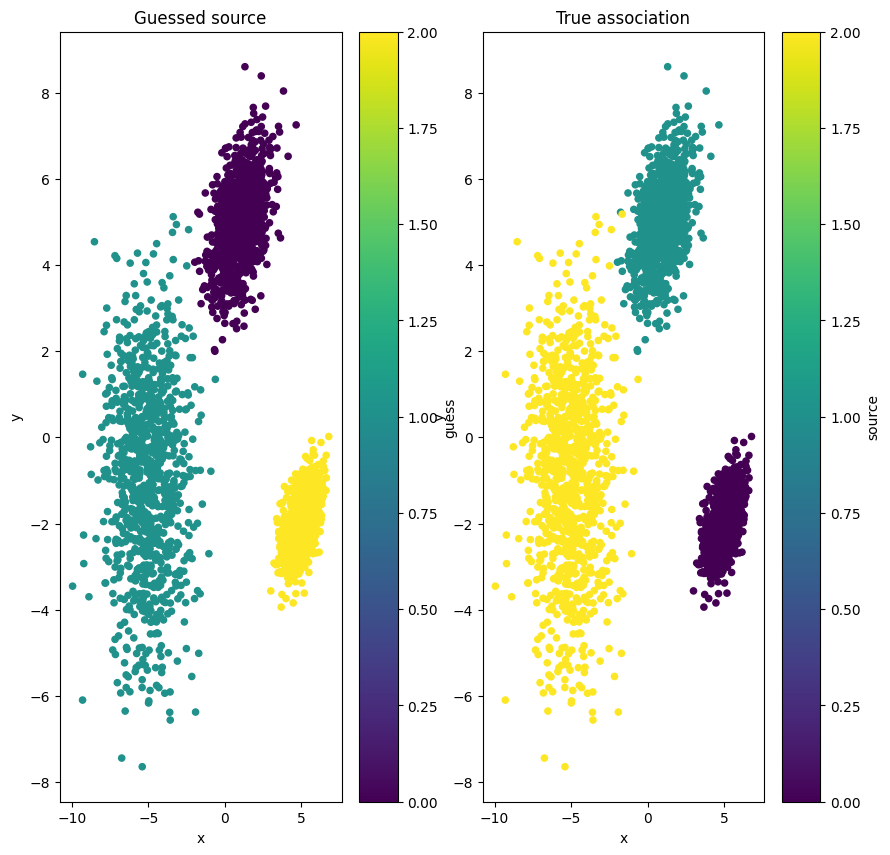

In [16]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2)
data.plot.scatter(x="x", y="y", c="guess", colormap='viridis', ax=ax[0])
data.plot.scatter(x="x", y="y", c="source", colormap='viridis', ax=ax[1])
ax[0].set(xlabel="x", ylabel=r"y", title="Guessed source")
ax[1].set(xlabel="x", ylabel=r"y", title="True association")
plt.show()

Note that if the sample clusters were not "blobs" of data, but were in concentric circles, the assumption of this method would be false and the method would simply not work well. This is why it is important to understand the underlying assumptions made in the method.

## Determining the number of clusters

So far, we have assumed that the number of clusters is known. This is not often the case. One method to determine the number of clusters is to fit the GMM with different number of clusters and after each fit, calculate `gmm.bic()`. This method returns the Bayesian Information Criteria (see also AIC), which should be small when the fit worked well and the number of components is compatible with your sample.

See a full example here: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

## K-Means

Another common method used for clustering is the K-Means, on which one simply tries to find the cluster centers which minimize in-cluster distances (in an Euclidean sense) while maximizing distances between the centers. It can be shown that this method is a special case of the Gaussian Mixture Model when the covariance matrices are diagonal, which would mean that within each blob, there is no correlation between the variables (see https://en.wikipedia.org/wiki/K-means_clustering#Gaussian_mixture_model and references).

While this is an approximation of the GMM model, it is still a very useful approach, since there are faster algorithms to achieve the clustering than for GMMs.

The scikit-learn module also provides an easy-to-use implementation of this algorithm:

In [17]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data.loc[:, ["x", "y"]])

/home/daniloefl/workspace/ml-lecture-problems/ml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [18]:
data.loc[:, "guess_kmeans"] = kmeans.predict(data.loc[:, ["x", "y"]])

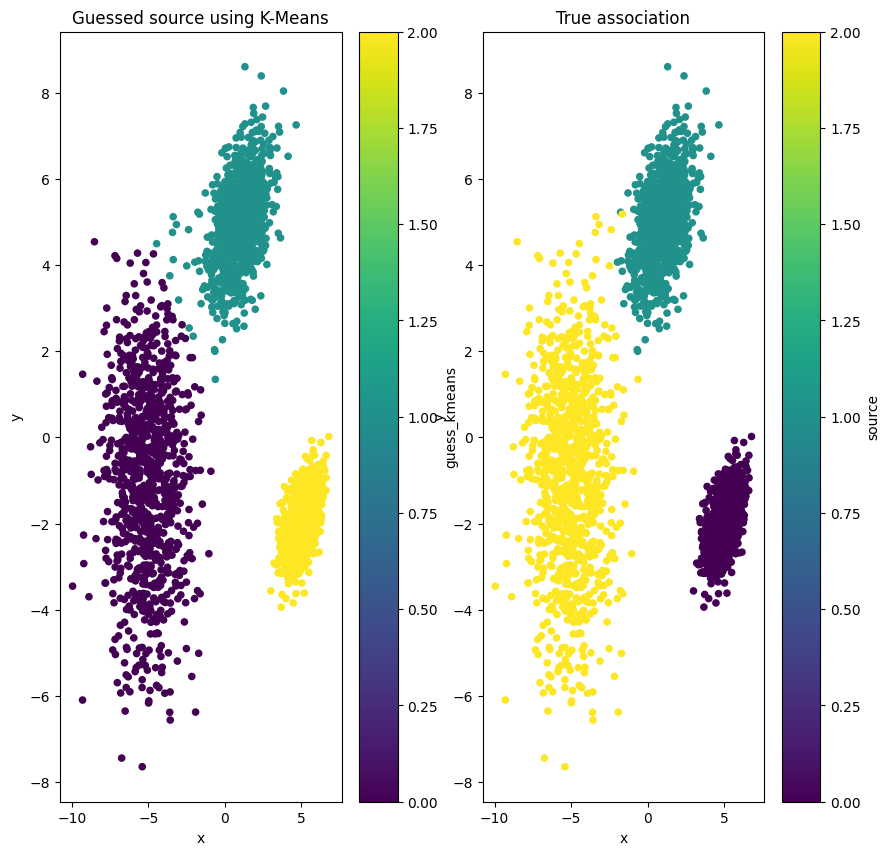

In [19]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2)
data.plot.scatter(x="x", y="y", c="guess_kmeans", colormap='viridis', ax=ax[0])
data.plot.scatter(x="x", y="y", c="source", colormap='viridis', ax=ax[1])
ax[0].set(xlabel="x", ylabel=r"y", title="Guessed source using K-Means")
ax[1].set(xlabel="x", ylabel=r"y", title="True association")
plt.show()

## Variational Inference on Gaussian Mixture Models

While the Gaussian Mixture Model presented beforehand had a very strong theoretical background, it still assumes that there is a single correct value for the Gaussian parameters. This may not be the case if the Gaussian model is only approximate (as is very often the case!).

One improvement to the Gaussian Mixture Models to allow for the usage of prior knowledge (a prior) on the parameters to be discovered. This helps us, for instance, to determine the ideal number of components automatically, since the number of components itself can be fit with it (assuming a prior distribution on them).

Optimizing this model becomes even more complicated as the derivation shown before and if we wanted to be fully general, we would need to use very slow algorithms, such as Monte-Carlo sampling to obtain uncertainties with the least amount of extra assumptions. This is often undesirable, since we need fast clustering and often Monte-Carlo sampling is very slow with even more data! An alternative is to assume some underlying prior probability for the means and covariances and find those parameters as well in an optimization algorithm. This is what is done in Variational Inference. Further details can be seen in Bishop (2006), or in a more practical approach, here: https://scikit-learn.org/stable/modules/mixture.html#bgmm

We can also easily use this method in our toy data, taking the code from scikit-learn:

In [20]:
bgmm = BayesianGaussianMixture(n_components=3)
bgmm.fit(data.loc[:, ["x", "y"]])
data.loc[:, "guess_bgmm"] = bgmm.predict(data.loc[:, ["x", "y"]])

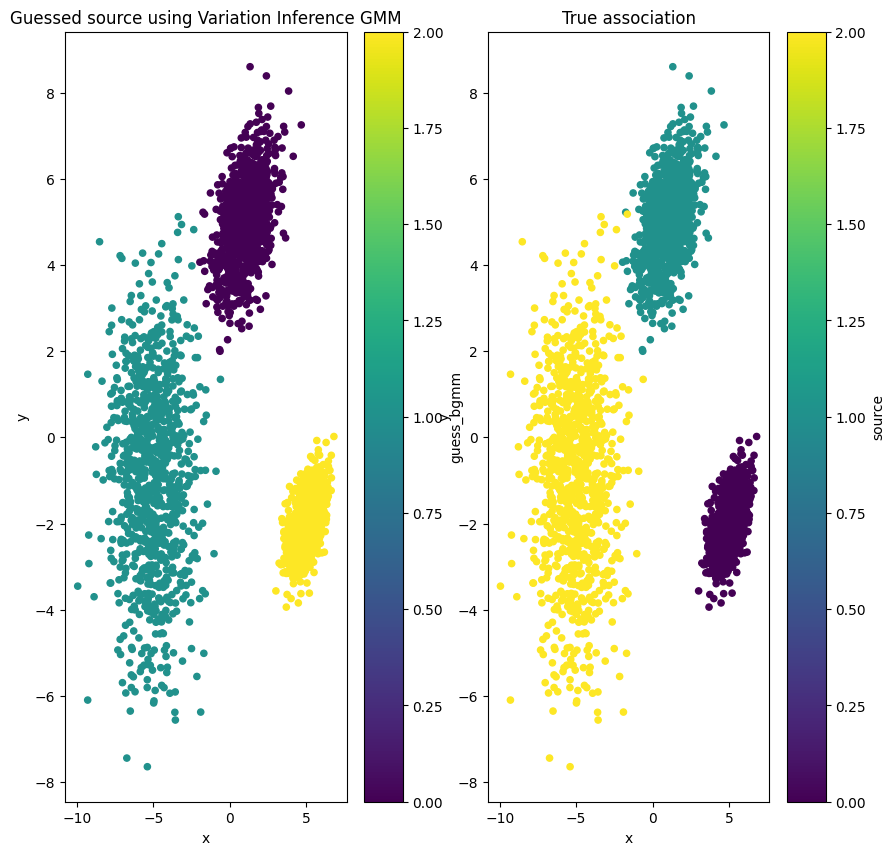

In [21]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=2)
data.plot.scatter(x="x", y="y", c="guess_bgmm", colormap='viridis', ax=ax[0])
data.plot.scatter(x="x", y="y", c="source", colormap='viridis', ax=ax[1])
ax[0].set(xlabel="x", ylabel=r"y", title="Guessed source using Variation Inference GMM")
ax[1].set(xlabel="x", ylabel=r"y", title="True association")
plt.show()

## Other heuristic approaches

Many other heuristic approaches for clustering have been developed. Some of them rely on a strong foundation in statistics, others take a more practical approach and make assumptions on how the data samples are expected to be distributed in the $xy$ scatter plot. The following methods deserve a look if you are not familiar with them already:

  * DBSCAN (see https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html ). Uses the euclidean distances between the samples to define if a sample belongs in a cluster or another. The assumption is related to GMMs. While the GMM requires fixing the number of clusters, DBSCAN relies on the maximum distance parameter do define which samples belong to a cluster.
  * Agglomerative clustering (see https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering). It uses the nearest neighbour to each sample to define which samples belong together in the same cluster. Since the cluster association is topological, it does not assume the samples make a "blob" of some sort, as in the case of GMM. One could for example have samples close to one another making a circle in the $xy$-scatter plane and those samples would belong to the same cluster (depending on the definition of closeness and other parameters of the algorithm).
  * Spectral clustering (see https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Uses K-means on another representation of the data. This representation of the data transforms the data points from the $xy$ space shown before into a space where connectedness of nearest neighbours is the criteria for similarity. For the mathematical foundation, this document may be useful: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.165.9323&rep=rep1&type=pdf
  